In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
import pandas as pd 
import numpy as np
import os 
import datetime
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import plotly.express as px

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.window import Window
from math import radians, cos, sin, asin, sqrt
from pyspark.sql import functions as F
from pyspark.sql.functions import col, row_number, count, when, isnan, abs, cos, atan2

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

from cmath import pi
from math import atan2, radians

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "48g").config("spark.driver.memory", "48g").config("spark.driver.maxResultSize","0").config("spark.executor.heartbeatInterval","100000").getOrCreate()

In [4]:
gdrive_path = 'C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\'

In [5]:
parquet_path = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\joined_data_v4_10_3_22.parquet'

In [6]:
df_all = spark.read.parquet(parquet_path)

In [7]:
columns_to_keep = ["year", "cdscode", "school_county", "school_zip", "school_region_name", "school_open_date", "school_closed_date", "school_lat", "school_lon", "school_wspd", "school_elevation_m", "year_month", "total_population", "total_population_male", "total_population_female", "population_0_4", "population_0_4_male", "population_0_4_female", "population_5_9", "population_5_9_male", "population_5_9_female", "population_10_14", "population_10_14_male", "population_10_14_female", "population_15_19", "population_15_19_male", "population_15_19_female", "pop_under19_male", "pop_under19_female", "total_pop_under19", "pm25", "point_source_lat", "point_source_lon", "ps_elevation_m", "point_source_pm25_tpy", "dist_school_to_ps_m", "angle_to_school", "ps_wind_lat", "ps_wind_lon", "ps_wspd_merge", "school_wdir_wrt_0N", "ps_wdir_wrt_0N", "school_wind_alignment", "ps_wind_alignment", "avg_wind_speed", "avg_wind_alignment", "avg_wind_alignment_cosine"]

In [8]:
df_all_subset = df_all.select(columns_to_keep)

In [9]:
# spot check for nulls

df_all_subset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_all_subset.columns]).show()

+----+-------+-------------+----------+------------------+----------------+------------------+----------+----------+-----------+------------------+----------+----------------+---------------------+-----------------------+--------------+-------------------+---------------------+--------------+-------------------+---------------------+----------------+---------------------+-----------------------+----------------+---------------------+-----------------------+----------------+------------------+-----------------+------+----------------+----------------+--------------+---------------------+-------------------+---------------+-----------+-----------+-------------+------------------+--------------+---------------------+-----------------+--------------+------------------+-------------------------+
|year|cdscode|school_county|school_zip|school_region_name|school_open_date|school_closed_date|school_lat|school_lon|school_wspd|school_elevation_m|year_month|total_population|total_population_male|t

In [10]:
pd_df_all = df_all_subset.toPandas()

In [11]:
display(pd_df_all)

,year,cdscode,school_county,school_zip,school_region_name,school_open_date,school_closed_date,school_lat,school_lon,school_wspd,school_elevation_m,year_month,total_population,total_population_male,total_population_female,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,pop_under19_male,pop_under19_female,total_pop_under19,pm25,point_source_lat,point_source_lon,ps_elevation_m,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wind_lat,ps_wind_lon,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine
0,2010.0,20102070109728,Madera,93610,Northern San Joaquin Valley,8/16/2005,6/30/2014,37.115210,-120.26603,1.531352,70.84,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968
1,2010.0,20102072030187,Madera,93610,Northern San Joaquin Valley,1/22/2001,6/30/2014,37.115210,-120.26603,1.531352,70.84,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968
2,2010.0,20651930000000,Madera,93610,Northern San Joaquin Valley,No Data,No Data,37.122449,-120.26487,1.531352,72.77,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2358.38241919395,-37.54028477906731,NaN,NaN,1.531352,102.528057,102.528057,140.068342,140.068342,1.531352,140.068342,0.233189
3,2010.0,20651930113076,Madera,93610,Northern San Joaquin Valley,8/21/2007,No Data,37.131113,-120.242025,1.531352,77.12,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2892.9075458251764,11.831222108044384,NaN,NaN,1.531352,102.528057,102.528057,90.696835,90.696835,1.531352,90.696835,0.987838
4,2010.0,20651936023907,Madera,93610,Northern San Joaquin Valley,7/1/1980,No Data,37.115243,-120.26777,1.531352,70.66,2010-04,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2004.5665433091058,-57.72695665034661,NaN,NaN,1.531352,102.528057,102.528057,160.255014,160.255014,1.531352,160.255014,0.058794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983106,2016.0,31669443138500,Placer,96161,Superior California,7/1/1980,No Data,39.324762,-120.214355,0.168952,1794.66,2016-06,18255.0,9580.0,8675.0,1113.555,450.26,667.975,1259.595,766.4,494.475,1405.635,670.6,737.375,967.515,622.7,355.675,2509.960,2255.5,4746.3,1.9043859,39.32004,-120.13956,1797.86,1.693825957653,6470.985860231626,-85.32941655311153,39.184,-120.427,0.168952,2.570111,2.570111,87.899527,87.899527,0.168952,87.899527,1.036652
2983107,2016.0,31669446031298,Placer,96161,Superior California,7/1/1980,No Data,39.316133,-120.455805,0.168952,1840.70,2016-06,18255.0,9580.0,8675.0,1113.555,450.26,667.975,1259.595,766.4,494.475,1405.635,670.6,737.375,967.515,622.7,355.675,2509.960,2255.5,4746.3,1.9043859,39.32004,-120.13956,1797.86,1.693825957653,27275.519628087517,-90.81101700875263,39.184,-120.427,0.168952,2.570111,2.570111,93.381128,93.381128,0.168952,93.381128,0.941022
2983108,2016.0,3166944603132

<AxesSubplot:>

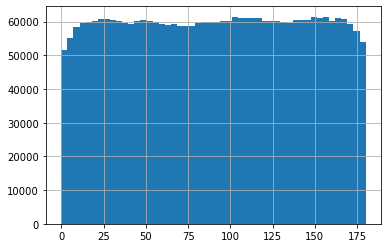

In [12]:
pd_df_all.avg_wind_alignment.hist(bins=50)

<AxesSubplot:>

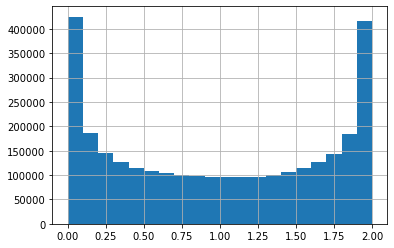

In [13]:
pd_df_all.avg_wind_alignment_cosine.hist(bins=20)

<AxesSubplot:>

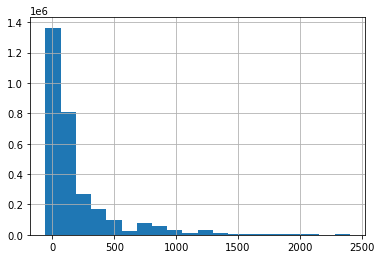

In [14]:
pd_df_all.school_elevation_m.hist(bins=20)

<AxesSubplot:>

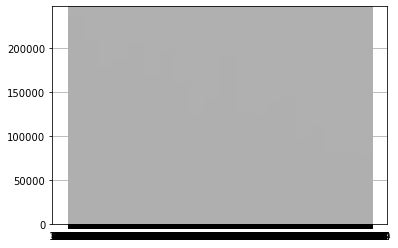

In [15]:
pd_df_all.ps_elevation_m.hist(bins=20)

<AxesSubplot:>

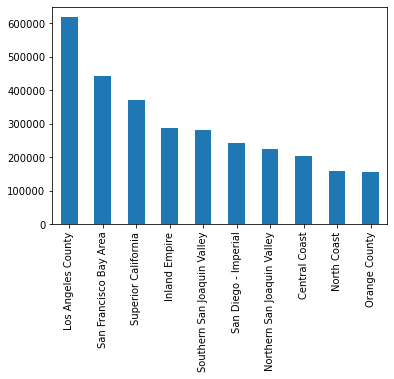

In [16]:
pd_df_all['school_region_name'].value_counts().plot(kind='bar')

In [17]:
pd_df_all.to_parquet('C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\joined_filtered_data.parquet')

In [18]:
pd_df_all.to_csv('C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\joined_filtered_data.csv')